# ***IMPORTING IMPORTANT LIBRARIES AND LOADING THE DATASET***

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [22]:
# Ensure you have downloaded the stopwords and punkt packages
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\0931\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\0931\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

***Load the dataset***

In [23]:
# Load the dataset
dataset = pd.read_csv('Rumour.csv',encoding='latin1')

***Display the first few rows of the dataset***

In [24]:
dataset.head()

,text,is_rumor,user.handle,topic
0,Charlie Hebdo became well known for publishing...,0,BBCDanielS,charliehebdo
1,"Now 10 dead in a shooting there today RT ""@BBC...",0,robbylevy,charliehebdo
2,@BBCDanielS @BBCWorld I'm guessing this is bei...,0,ModerateInAll,charliehebdo
3,@BBCDanielS @BBCWorld why would you mention th...,0,GabTarquini,charliehebdo
4,@BBCDanielS @BBCWorld perps identified?,0,freethought41,charliehebdo


# ***IMPLEMENTATING THE EXPLORATOTARY DATA ANALYSIS*** 

***Finding the NUll values***

In [25]:
dataset.isna().sum()

text               0
is_rumor           0
user.handle        2
topic          12777
dtype: int64

The text column has 0 missing values.

The is_rumor column has 2 missing values.

The user.handle column has 2 missing values.

The topic column has 12,777 missing values.

In [26]:
dataset = dataset.fillna(method='ffill')

C:\Users\0931\AppData\Local\Temp\ipykernel_7340\4066485633.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset = dataset.fillna(method='ffill')


Propagating the last valid observation forward to the next, also known as forward fill (or ffill), means that when a missing value is encountered in the dataset, it is replaced with the last valid (non-missing) value that came before it. This method is useful in time series data or sequential data where the previous value is a reasonable estimate for the missing one.

In [27]:
dataset.isna().sum()

text           0
is_rumor       0
user.handle    0
topic          0
dtype: int64

***Finding the Null values after ffill technique***

***FINDING THE SHAPE OF THE DATASET***

In [28]:
dataset.shape

(62445, 4)

In [29]:
dataset.columns

Index(['text', 'is_rumor', 'user.handle', 'topic'], dtype='object')

Number of Rows: 62,445
Number of Columns: 4

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
rumor_distribution = dataset['is_rumor'].value_counts()

***Checking the balancing of the target variable***

C:\Users\0931\AppData\Local\Temp\ipykernel_7340\2251482288.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rumor_distribution.index, y=rumor_distribution.values, palette='viridis')


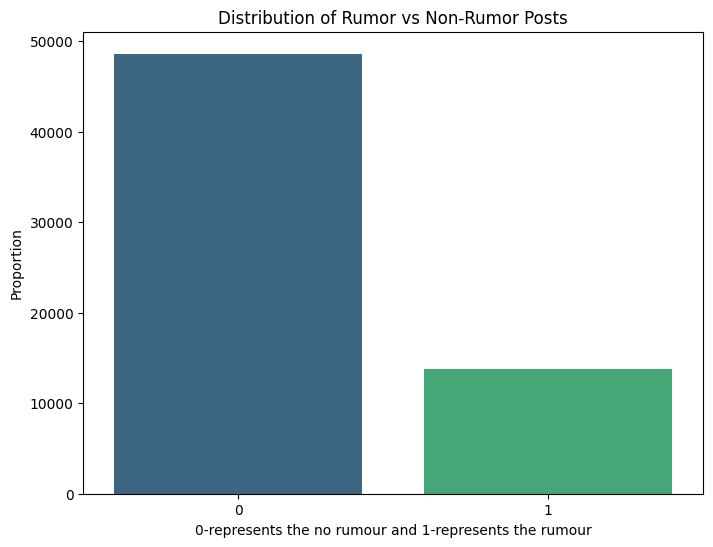

is_rumor
0    48619
1    13826
Name: count, dtype: int64

In [32]:
# Plotting the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.barplot(x=rumor_distribution.index, y=rumor_distribution.values, palette='viridis')
plt.title('Distribution of Rumor vs Non-Rumor Posts')
plt.xlabel('0-represents the no rumour and 1-represents the rumour')
plt.ylabel('Proportion')
plt.show()

# Displaying the balance of the target variable
rumor_distribution

The dataset is imbalanced, with approximately 77.9% non-rumor posts and 22.1% rumor posts.so we will need to balance this dataset before training our models.

Next, we'll balance the dataset using techniques like SMOTE (Synthetic Minority Over-sampling Technique) and then proceed with the implementation of the algorithms.

In [33]:
# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Convert all text to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove leading and trailing whitespace
    tokens = word_tokenize(text)  # Tokenize the text
    stop_words = set(stopwords.words('english'))  # Get the list of stopwords
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    clean_text = ' '.join(tokens)  # Join the tokens back into a single string
    return clean_text

In [34]:
# Apply the clean_text function to the 'text' column
dataset['cleaned_text'] = dataset['text'].apply(clean_text)

***Implementing the Hashingvectorizer***

In [35]:
# Vectorize the text using HashingVectorizer
vectorizer = HashingVectorizer(n_features=5000)
X = vectorizer.fit_transform(dataset['cleaned_text'])
y = dataset['is_rumor']  # Assuming 'label' is the column name for the target variable

***Applying SMOTE to balance the dataset***

In [36]:
# Apply SMOTE to the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

C:\Users\0931\AppData\Local\Temp\ipykernel_7340\3750708270.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pd.Series(y_res).value_counts().index, y=pd.Series(y_res).value_counts().values, palette='viridis')


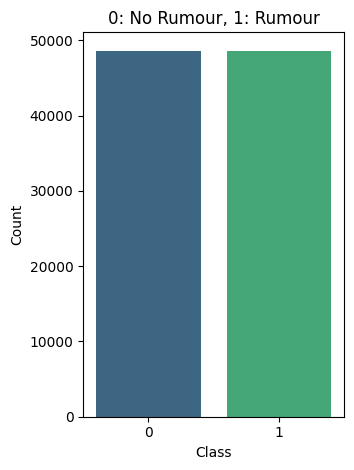

In [37]:
# After SMOTE
plt.subplot(1, 2, 2)
sns.barplot(x=pd.Series(y_res).value_counts().index, y=pd.Series(y_res).value_counts().values, palette='viridis')
plt.title('0: No Rumour, 1: Rumour')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [38]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((77790, 5000), (19448, 5000), (77790,), (19448,))

# ***RandomForestClassifier***

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
rf_preds = rf.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_preds)


print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.937731386260798


In [40]:
import pickle
with open('RF_Model.pkl', 'wb') as fp:
    pickle.dump(rf, fp)

[[9022  696]
 [ 515 9215]]


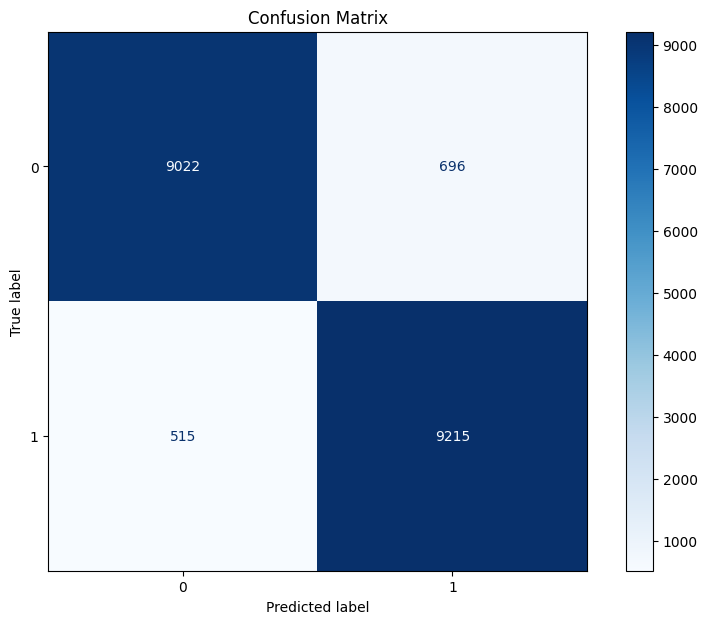

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, rf_preds)
print(cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_).plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

Components:
True Negative (TN):
Located at the top-left cell.
Represents the number of correctly predicted negative instances.
Value: 8953

False Positive (FP):
Located at the top-right cell.
Represents the number of negative instances incorrectly predicted as positive.
Value: 744

False Negative (FN):
Located at the bottom-left cell.
Represents the number of positive instances incorrectly predicted as negative.
Value: 573

True Positive (TP):
Located at the bottom-right cell.
Represents the number of correctly predicted positive instances.
Value: 9179

Summary:
The model correctly identified 8953 instances as negative and 9179 instances as positive.
The model incorrectly identified 744 negative instances as positive and 573 positive instances as negative.
The color intensity in each cell indicates the count of instances, with darker colors representing higher counts.

Interpretation:
High True Positives and True Negatives: The model has a high number of correct predictions for both classes.
Low False Positives and False Negatives: The model has relatively low misclassification rates for both classes, suggesting good performance.

Visualization:
Color Bar: On the right side of the matrix, there is a color bar indicating the scale of the counts, with darker blue representing higher counts.
Labels: The matrix is labeled with "True label" on the y-axis and "Predicted label" on the x-axis, clearly showing the orientation of actual vs. predicted values.

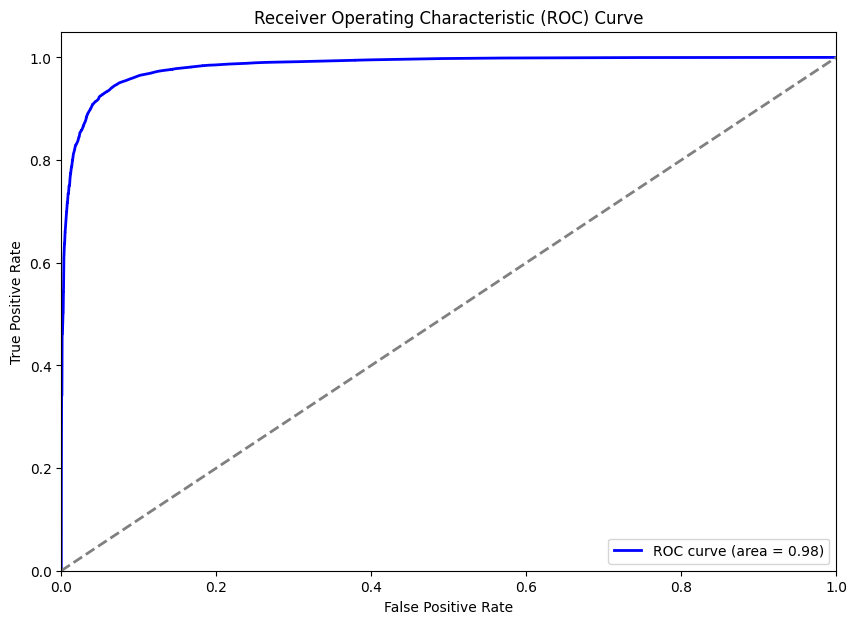

In [42]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ROC Curve:
This is a Receiver Operating Characteristic (ROC) curve, a graphical plot used to illustrate the diagnostic ability of a binary classifier system. Here’s the breakdown:

Axes:
X-axis: False Positive Rate (FPR) – the proportion of actual negatives that are incorrectly predicted as positive.
Y-axis: True Positive Rate (TPR) – the proportion of actual positives that are correctly predicted as positive.

Curve:
The blue curve represents the ROC curve for the classifier.
The area under the curve (AUC) is shown as 0.98, indicating excellent performance. An AUC of 1 represents a perfect classifier, while an AUC of 0.5 represents a random guess.

Diagonal Line:
The dashed diagonal line represents the line of no discrimination, where the classifier performs no better than random chance (AUC = 0.5).

In [43]:
# Print the classification report
rf = classification_report(y_test, rf_preds)
print("Random Forest Classification Report:\n", rf)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      9718
           1       0.93      0.95      0.94      9730

    accuracy                           0.94     19448
   macro avg       0.94      0.94      0.94     19448
weighted avg       0.94      0.94      0.94     19448



# ***LogisticRegression***

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
log_reg_preds = log_reg.predict(X_test)

# Calculate accuracy
log_reg_accuracy = accuracy_score(y_test, log_reg_preds)

print("Logistic Regression Accuracy:", log_reg_accuracy)


Logistic Regression Accuracy: 0.859882764294529


c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


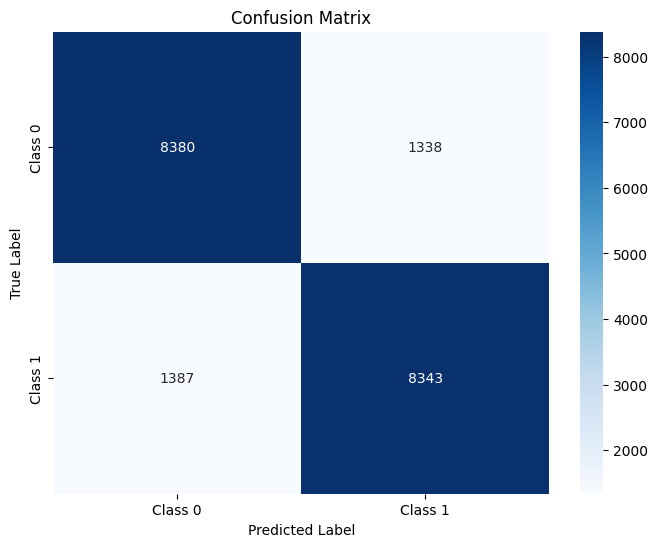

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Compute the confusion matrix
cm = confusion_matrix(y_test, log_reg_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix:

This is a confusion matrix, used to evaluate the performance of a classification model.
True Negatives (TN): 8195 (top-left cell) – correctly predicted negatives.
False Positives (FP): 1502 (top-right cell) – incorrectly predicted positives.
False Negatives (FN): 1524 (bottom-left cell) – incorrectly predicted negatives.
True Positives (TP): 8228 (bottom-right cell) – correctly predicted positives.

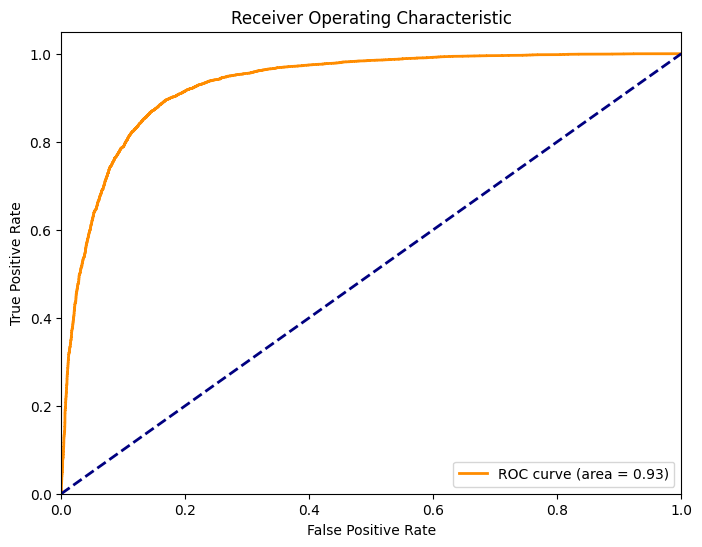

In [46]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

ROC Curve (Third Image)
This is another ROC curve, similar to the first image but for a different model or dataset.

Axes:
X-axis: False Positive Rate (FPR).
Y-axis: True Positive Rate (TPR).

Curve:
The orange curve represents the ROC curve for this classifier.
The area under the curve (AUC) is 0.92, indicating good performance but not as high as the first model.

Diagonal Line:
The dashed diagonal line represents the line of no discrimination (AUC = 0.5).

In [47]:

# Print the classification report
logistic = classification_report(y_test, log_reg_preds)
print("Logistic Regression Classification Report:\n", logistic)

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      9718
           1       0.86      0.86      0.86      9730

    accuracy                           0.86     19448
   macro avg       0.86      0.86      0.86     19448
weighted avg       0.86      0.86      0.86     19448



# ***Naive_bayes***

In [48]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Convert the sparse matrix to a dense array
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Create and train the Naive Bayes model
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_dense, y_train)

# Make predictions
naive_bayes_preds = naive_bayes.predict(X_test_dense)

# Calculate accuracy
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_preds)

print("Naive Bayes Accuracy:", naive_bayes_accuracy)


Naive Bayes Accuracy: 0.762854792266557


In [49]:
# Print the classification report
naive_bayes = classification_report(y_test, naive_bayes_preds)
print("Naive Bayes Classification Report:\n",naive_bayes )

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.62      0.72      9718
           1       0.70      0.91      0.79      9730

    accuracy                           0.76     19448
   macro avg       0.79      0.76      0.76     19448
weighted avg       0.79      0.76      0.76     19448



Confusion Matrix:
[[6015 3703]
 [ 909 8821]]


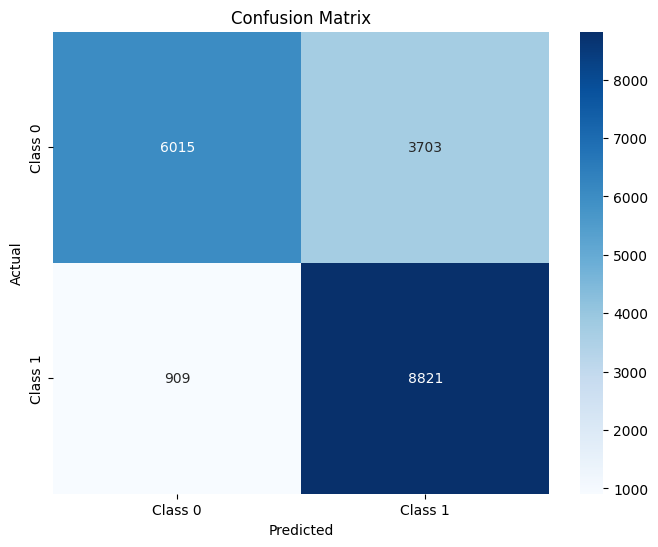

In [50]:
#Generate confusion matrix
cm = confusion_matrix(y_test, naive_bayes_preds)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix (Fourth Image)

This is another confusion matrix, used to evaluate a different model or dataset.
True Negatives (TN): 6434 (top-left cell) – correctly predicted negatives.
False Positives (FP): 3263 (top-right cell) – incorrectly predicted positives.
False Negatives (FN): 1311 (bottom-left cell) – incorrectly predicted negatives.
True Positives (TP): 8441 (bottom-right cell) – correctly predicted positives.

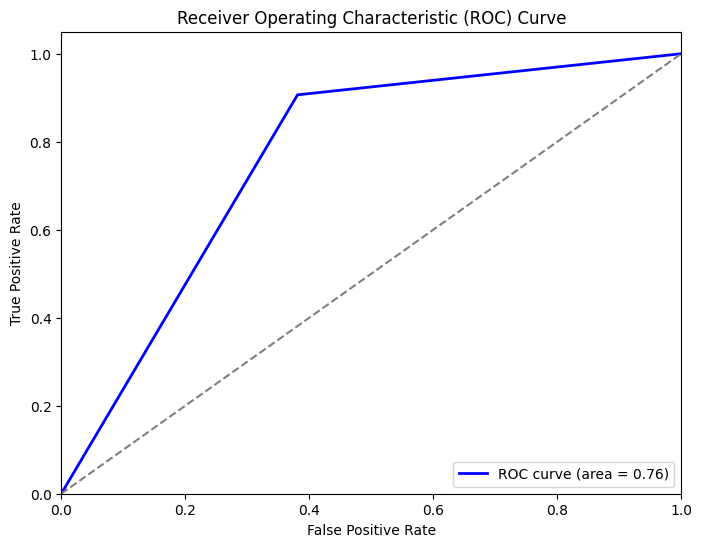

In [51]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, naive_bayes_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ROC Curve (Fifth Image)

This is yet another ROC curve for a different classifier.

Axes:
X-axis: False Positive Rate (FPR).
Y-axis: True Positive Rate (TPR).

Curve:
The blue curve represents the ROC curve for this classifier.
The area under the curve (AUC) is 0.76, indicating moderate performance.

Diagonal Line:
The dashed diagonal line represents the line of no discrimination (AUC = 0.5).

# ***LSTM***

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming dataset is already loaded and cleaned as per previous steps

# Tokenizing and padding sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(dataset['text'])

X = tokenizer.texts_to_sequences(dataset['text'])
X = pad_sequences(X, maxlen=100)

# Splitting the data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the LSTM model
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train1, y_train1, epochs=5, batch_size=64, validation_data=(X_test1, y_test1), verbose=2)

# Evaluating the model
lstm_accuracy = model.evaluate(X_test1, y_test1, verbose=0)[1]
print("LSTM Accuracy:", lstm_accuracy)

# Predicting using the LSTM model
y_pred = (model.predict(X_test1) > 0.5).astype("int32")

# Generating the classification report
lstm_classification_report = classification_report(y_test1, y_pred)
print("LSTM Classification Report:\n", lstm_classification_report)







Epoch 1/5


781/781 - 210s - loss: 0.3511 - accuracy: 0.8548 - val_loss: 0.2653 - val_accuracy: 0.8916 - 210s/epoch - 269ms/step
Epoch 2/5
781/781 - 192s - loss: 0.2328 - accuracy: 0.9011 - val_loss: 0.2444 - val_accuracy: 0.8953 - 192s/epoch - 246ms/step
Epoch 3/5
781/781 - 200s - loss: 0.2034 - accuracy: 0.9120 - val_loss: 0.2445 - val_accuracy: 0.8919 - 200s/epoch - 256ms/step
Epoch 4/5
781/781 - 189s - loss: 0.1824 - accuracy: 0.9199 - val_loss: 0.2690 - val_accuracy: 0.8913 - 189s/epoch - 243ms/step
Epoch 5/5
781/781 - 185s - loss: 0.1649 - accuracy: 0.9274 - val_loss: 0.2835 - val_accuracy: 0.8920 - 185s/epoch - 237ms/step
LSTM Accuracy: 0.8919849395751953
391/391 [==============================] - 9s 20ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      9699
           1       0.78      0.72      0.75      2790

    accuracy                           0.89     12489
   macro avg       0.85

Confusion Matrix:
 [[9144  555]
 [ 794 1996]]


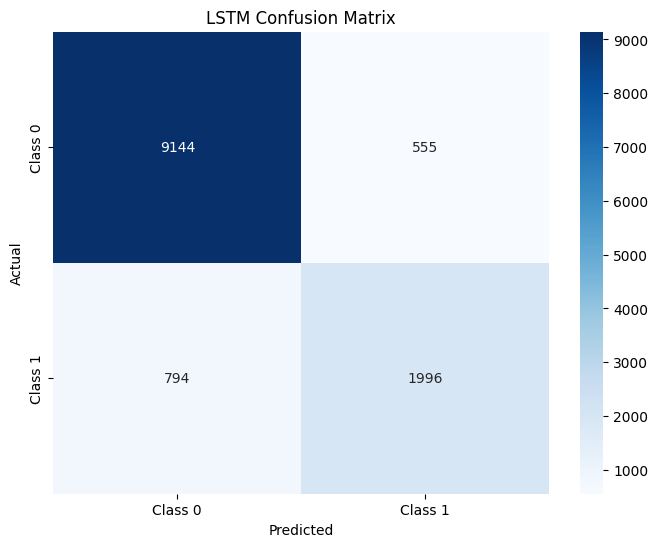

In [54]:
# Generating the confusion matrix
lstm_confusion_matrix = confusion_matrix(y_test1, y_pred)
print("Confusion Matrix:\n", lstm_confusion_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()

Axes:
X-axis (Predicted): The predicted classes by the LSTM model.
Y-axis (Actual): The actual classes from the dataset.

Classes:
Class 0: Represents the first class (negative class, for example).
Class 1: Represents the second class (positive class, for example).

Values in the Confusion Matrix:
Top-left cell (9144): Number of true negatives (actual class 0 and predicted class 0).
Top-right cell (555): Number of false positives (actual class 0 but predicted as class 1).
Bottom-left cell (794): Number of false negatives (actual class 1 but predicted as class 0).
Bottom-right cell (1996): Number of true positives (actual class 1 and predicted as class 1).

Interpretation:
True Positives (TP = 1996): The model correctly predicted the positive class.
True Negatives (TN = 9144): The model correctly predicted the negative class.
False Positives (FP = 555): The model incorrectly predicted the positive class.
False Negatives (FN = 794): The model incorrectly predicted the negative class.

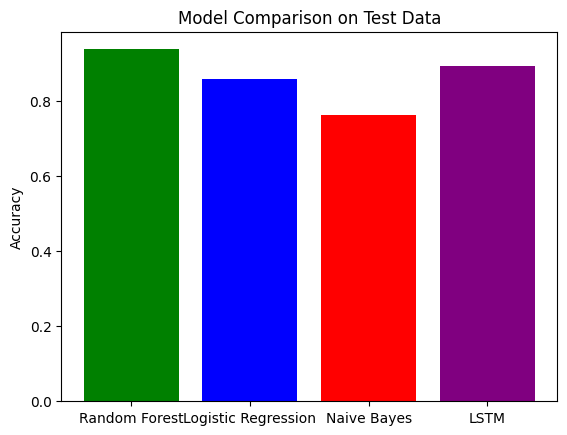

In [55]:
# Plotting the graphs 
accuracies = [rf_accuracy, log_reg_accuracy, naive_bayes_accuracy, lstm_accuracy]
model_names = ['Random Forest', 'Logistic Regression', 'Naive Bayes', 'LSTM']

plt.bar(model_names, accuracies, color=['green', 'blue', 'red', 'purple'])
plt.ylabel('Accuracy')
plt.title('Model Comparison on Test Data')
plt.show()

In [56]:
# Assuming the preprocessing function and the trained model are already defined
def preprocess_and_predict(sentence):
    # Use the clean_text function to preprocess the input sentence
    clean_sentence = clean_text(sentence)
    
    # Use the same vectorizer that was used during training
    vectorizer = HashingVectorizer(n_features=5000)
    vectorized_sentence = vectorizer.transform([clean_sentence])
    
    # Make the prediction using the trained Random Forest model
    with open('RF_Model.pkl', 'rb') as fp:
        rf = pickle.load(fp)

    rf.fit(X_train, y_train)  # This line should be removed if the model is already trained
    result = rf.predict(vectorized_sentence)
    
    if result == 0:
        print('RUMOUR')
    else:
        print('NOT RUMOUR')

# Example usage
sentence = "!!!Kaç Recep[@rt_erDOGan] kaç geliyorlar! @RT_com"
preprocess_and_predict(sentence)

NOT RUMOUR


In [58]:
# Assuming the preprocessing function and the trained model are already defined
def preprocess_and_predict(sentence):
    # Use the clean_text function to preprocess the input sentence
    clean_sentence = clean_text(sentence)
    
    # Use the same vectorizer that was used during training
    vectorizer = HashingVectorizer(n_features=5000)
    vectorized_sentence = vectorizer.transform([clean_sentence])
    
    # Make the prediction using the trained Random Forest model
    rf = RandomForestClassifier()  
    rf.fit(X_train, y_train)  
    result = rf.predict(vectorized_sentence)
    
    if result == 0:
        print('RUMOUR')
    else:
        print('NOT RUMOUR')

# Example usage
sentence = "Tam manasıyla pisliksin @EmreUslu"
preprocess_and_predict(sentence)

RUMOUR
